conda create --name applied_project numpy ipykernel jupyter pandas matplotlib yfinance ta conda-forge::scikit-learn

# Data Preparation
- Gold Features: Open, High, Low, Volume, Lagged Features, Returns, Price Changes
- Technical Features: MA, EMA, Bollinger Bands, RSI, MACD, ATR
- Macro Features: USD Index DXY, Crude Oil Index, Interest Rates, CPI, S&P 500 Index, VIX, Money Supply
- Categorical Features: Date, Month, Year, Day

In [181]:
import pandas as pd

# Process Gold Features
df = pd.read_csv("Gold Futures Historical Data.csv")
print(df.columns)
print(df.shape)

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change'], dtype='object')
(4965, 7)


In [182]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y", errors='coerce')

# Make sure no NaT
missing_dates: int = df['date'].isna().sum()
print(missing_dates) # 0

# Sort by date, asc
df = df.sort_values('date').reset_index(drop=True)

# Create year, month and quarter columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter


0


In [183]:
# Fix variable data types - convert to numeric
# Remove final char from volume and change
df['volume'] = df['volume'].str[:-1]
df['change'] = df['change'].str[:-1]

# Remove commas and convert to float
df[["open", "price", "high", "low", "volume", "change"]] = df[["open", "price", "high", "low", "volume", "change"]].replace(',', '', regex=True).astype(float).round(2)
print(df.dtypes)

date       datetime64[ns]
price             float64
open              float64
high              float64
low               float64
volume            float64
change            float64
year                int32
month               int32
quarter             int32
dtype: object


C:\Users\marty_xtbhkav\AppData\Local\Temp\ipykernel_57324\3720098556.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(loc=position, column=col_name, value=col_val)


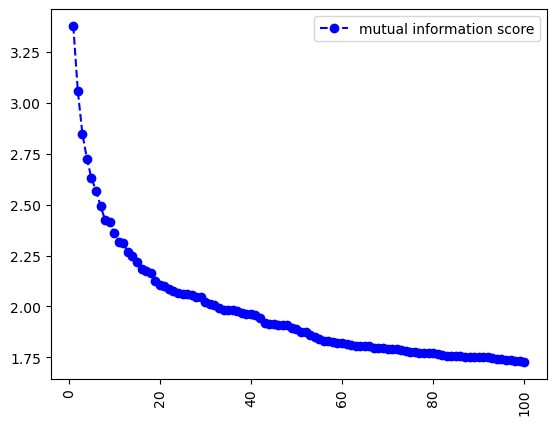

In [184]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_selection import mutual_info_regression

# add lags we set in "lag_list" and place them in order to the dataset.
def Add_Lag(data,col,lag_list):
    position = data.columns.tolist().index(col)

    for lag in lag_list:
        col_val = data[col].shift(lag)
        col_name = col+'_lag:'+'{length}'.format(length=lag)
        data.insert(loc=position, column=col_name, value=col_val)
    return data

def mutual_information_lag(Data,col,n_lag,k_best):
    
    #create a dataset by selecting just one column from Gold dataset; a dataset with just one column of {Open,Close,High,Low,Volume} and time as index
    data = pd.DataFrame(Data[col])
    
    #create the dataset that its columns are lags with different shifts
    mic_df = Add_Lag(data,col,[i+1 for i in range(n_lag)])
    mic_ordered = {}
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for i in range(1,n_lag+1):
        
        i_lag = mic_df[mic_df.columns[mic_df.shape[1]-i-1]][i:]
        i_lag_name = mic_df.columns[mic_df.shape[1]-i-1]
        score = mutual_info_regression(np.array(i_lag).reshape(-1, 1), mic_df[col][i:])
        mic_ordered[i_lag_name] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_lags = list(sorted_mic.keys())[:k_best]
    
    #create a list of best k lags obtained above
    select_lag_num = []
    for i in selected_lags:
        
        pos = i.find(':')
        select_lag_num.append(int(i[pos+1:]))
        
    select_lag_num_sort = sorted(select_lag_num)
    
    #draw a plot that visualize all lags (not just best k lags) and their mutul information score with the target
    plt.plot([i+1 for i in range(n_lag)], sorted_mic.values(),'--bo', label = "mutual information score")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    
    return select_lag_num_sort,sorted_mic,selected_lags,sorted_mic.values()

best_lags = mutual_information_lag(df,'open',100,10)

In [ ]:
# Visually, we can see lags 1 and 2 contain the most information
columns_to_lag = ['price', 'open', 'volume']

for col in columns_to_lag:
    for lag in [1,2]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

df.columns

TA Technical Indicators:

Trend Indicators

Momentum Indicators

Volatility Indicators

In [98]:
# Add Technical Features
import ta

# Initialize ta features (adds automatically NaNs at the beginning)
# 1. Trend Indicators
df['SMA_10'] = ta.trend.SMAIndicator(close=df['close'], window=10).sma_indicator()
df['EMA_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator()
macd = ta.trend.MACD(close=df['close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# 2. Momentum Indicators
df['RSI'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'])
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

# 3. Volatility Indicators
boll = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['BB_upper'] = boll.bollinger_hband()
df['BB_lower'] = boll.bollinger_lband()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()

IndexError: index 13 is out of bounds for axis 0 with size 0